use python 3.8.10 due to adafair dependencies


In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import StratifiedShuffleSplit
from adafair import AdaFair
from sklearn.ensemble import AdaBoostClassifier
from adafair import load_adult
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import scipy.stats as stats
import dice_ml
from dice_ml.utils import helpers
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import hashlib

import random
SEED = 23
random.seed(SEED)
np.random.seed(SEED)


Preprocessing of the datasets:

loading/preprocessing of datasets done based on description of https://wires.onlinelibrary.wiley.com/doi/10.1002/widm.1452

In [2]:
def load_communities():
    # Define the column names based on the dataset description
    columns = [
        'state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize',
        'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
        'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage',
        'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc',
        'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap',
        'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad',
        'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ',
        'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv',
        'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par',
        'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig',
        'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig',
        'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell',
        'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous',
        'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR',
        'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded',
        'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart',
        'OwnOccMedVal', 'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent',
        'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters',
        'NumStreet', 'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85', 'PctSameCity85',
        'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
        'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic',
        'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp',
        'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
        'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars',
        'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
        'PolicBudgPerPop', 'ViolentCrimesPerPop'
    ]
    
    df = pd.read_csv("C:/Users/cas/Documents/CSAI/thesis/data_sets/communities+and+crime/communities.data", header=None, names=columns, na_values='?') # change path to your own
    df = df.rename(columns={'ViolentCrimesPerPop': 'class'}) # rename to obtain class variable
    df['class'] = df['class'].apply(lambda x: 1 if x >= 0.7 else -1) #binarize class column 1, -1 to be able to be accepted by adafair algorithm
    df['racepctblack'] = df['racepctblack'].apply(lambda x: 1 if x >= 0.06 else 0) # binarize protected attribute
    required_columns = [
        'racepctblack', 'pctWInvInc', 'pctWPubAsst', 'NumUnderPov', 'PctPopUnderPov',
        'PctUnemployed', 'MalePctDivorce', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam',
        'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'NumIlleg', 'PctIlleg',
        'PctPersOwnOccup', 'HousVacant', 'PctHousOwnOcc', 'PctVacantBoarded',
        'NumInShelters', 'NumStreet', 'class']
    df = df[required_columns] # keep only relevent colums
    df = df.dropna()                # drop rows with missing values
    df = df.drop_duplicates()       # drop duplicates: whole row the same
    return df
   
    

In [3]:
df_communities = load_communities()
print(f"Number of records after processing: {len(df_communities)}")
print("\nColumn names in the processed dataset:")
print(df_communities.columns.tolist())
print("\nprotected attribute distribution:")
print(df_communities['racepctblack'].value_counts()) # 1 being 0.06 or more percentage black population
print("\nclass distribution:")
print(df_communities['class'].value_counts()) # class distribution with  <30 days being 1


Number of records after processing: 1994

Column names in the processed dataset:
['racepctblack', 'pctWInvInc', 'pctWPubAsst', 'NumUnderPov', 'PctPopUnderPov', 'PctUnemployed', 'MalePctDivorce', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'NumIlleg', 'PctIlleg', 'PctPersOwnOccup', 'HousVacant', 'PctHousOwnOcc', 'PctVacantBoarded', 'NumInShelters', 'NumStreet', 'class']

protected attribute distribution:
1    1038
0     956
Name: racepctblack, dtype: int64

class distribution:
-1    1872
 1     122
Name: class, dtype: int64


In [4]:
df_communities.head()

,racepctblack,pctWInvInc,pctWPubAsst,NumUnderPov,PctPopUnderPov,PctUnemployed,MalePctDivorce,FemalePctDiv,TotalPctDiv,PersPerFam,...,PctTeen2Par,NumIlleg,PctIlleg,PctPersOwnOccup,HousVacant,PctHousOwnOcc,PctVacantBoarded,NumInShelters,NumStreet,class
0,0,0.60,0.15,0.08,0.19,0.27,0.68,0.75,0.75,0.35,...,0.56,0.04,0.14,0.55,0.21,0.52,0.05,0.04,0.0,-1
1,1,0.45,0.29,0.01,0.24,0.27,1.00,0.91,1.00,0.29,...,0.39,0.00,0.24,0.26,0.02,0.24,0.02,0.00,0.0,-1
2,1,0.39,0.40,0.01,0.27,0.36,0.63,0.71,0.70,0.45,...,0.43,0.01,0.46,0.42,0.01,0.41,0.29,0.00,0.0,-1
3,1,0.43,0.20,0.01,0.10,0.33,0.34,0.49,0.44,0.75,...,0.65,0.03,0.33,0.94,0.01,0.96,0.60,0.00,0.0,-1
4,0,0.68,0.11,0.00,0.06,0.12,0.22,0.20,0.21,0.51,...,0.85,0.00,0.06,0.89,0.01,0.87,0.04,0.00,0.0,-1


define the subpopulations within the data and display there sizes

In [5]:
# Extract groups for Communities and Crime Dataset
positive_protected_comm = df_communities[(df_communities['racepctblack'] == 1) & (df_communities['class'] == 1)]
negative_protected_comm = df_communities[(df_communities['racepctblack'] == 1) & (df_communities['class'] == -1)]
positive_non_protected_comm = df_communities[(df_communities['racepctblack'] == 0) & (df_communities['class'] == 1)]
negative_non_protected_comm = df_communities[(df_communities['racepctblack'] == 0) & (df_communities['class'] == -1)]

# Print the sizes of each group
print("Communities and Crime Dataset:")
print(f"Positive Protected: {len(positive_protected_comm)}")
print(f"Negative Protected: {len(negative_protected_comm)}")
print(f"Positive Non-Protected: {len(positive_non_protected_comm)}")
print(f"Negative Non-Protected: {len(negative_non_protected_comm)}")


Communities and Crime Dataset:
Positive Protected: 115
Negative Protected: 923
Positive Non-Protected: 7
Negative Non-Protected: 949


create the X, y variable and indicate the protected attribute


In [6]:
X_communities = df_communities.drop('class', axis=1).values
y_communities = df_communities['class'].values
saIndex_communities = 0  # 'racepctblack' is the first column
saValue_communities = 1  # Protected group: communities with higher black population

the code below for calculating the performance was reused from the repository of the adafair paper: https://github.com/iosifidisvasileios/AdaFair/blob/master/run_example.ipynb 

Moreover the stratifiedshufllesplit code has been adapted from this repository aswell.

In [7]:
def calculate_performance(data, labels, predictions, saIndex, saValue):
    tp_protected = 0.
    tn_protected = 0.
    fp_protected = 0.
    fn_protected = 0.

    tp_non_protected = 0.
    tn_non_protected = 0.
    fp_non_protected = 0.
    fn_non_protected = 0.
    for idx, val in enumerate(data):
        # protected population
        if val[saIndex] == saValue:
            # correctly classified
            if labels[idx] == predictions[idx]:
                if labels[idx] == 1:
                    tp_protected += 1.
                else:
                    tn_protected += 1.
            # misclassified
            else:
                if labels[idx] == 1:
                    fn_protected += 1.
                else:
                    fp_protected += 1.
        else:
            # correctly classified
            if labels[idx] == predictions[idx]:
                if labels[idx] == 1:
                    tp_non_protected += 1.
                else:
                    tn_non_protected += 1.
            # misclassified
            else:
                if labels[idx] == 1:
                    fn_non_protected += 1.
                else:
                    fp_non_protected += 1.

    tpr_protected = tp_protected / (tp_protected + fn_protected)
    tnr_protected = tn_protected / (tn_protected + fp_protected)

    tpr_non_protected = tp_non_protected / (tp_non_protected + fn_non_protected)
    tnr_non_protected = tn_non_protected / (tn_non_protected + fp_non_protected)

    output = dict()
    output["balanced_accuracy"] =( (tp_protected + tp_non_protected)/(tp_protected + tp_non_protected + fn_protected + fn_non_protected) +
                                   (tn_protected + tn_non_protected) / (tn_protected + tn_non_protected + fp_protected + fp_non_protected))*0.5

    output["accuracy"] = accuracy_score(labels, predictions)
    output["fairness"] = abs(tpr_non_protected - tpr_protected) + abs(tnr_non_protected - tnr_protected)
    output["TPR_protected"] = tpr_protected
    output["TPR_non_protected"] = tpr_non_protected
    output["TNR_protected"] = tnr_protected
    output["TNR_non_protected"] = tnr_non_protected
    return output

display the positive non protected group

In [8]:
# check query instance predictions in original model
query_instances= positive_non_protected_comm.drop('class', axis=1)
positive_non_protected_comm

,racepctblack,pctWInvInc,pctWPubAsst,NumUnderPov,PctPopUnderPov,PctUnemployed,MalePctDivorce,FemalePctDiv,TotalPctDiv,PersPerFam,...,PctTeen2Par,NumIlleg,PctIlleg,PctPersOwnOccup,HousVacant,PctHousOwnOcc,PctVacantBoarded,NumInShelters,NumStreet,class
78,0,0.34,0.61,0.19,0.57,0.62,0.69,0.64,0.69,0.45,...,0.45,0.07,0.30,0.58,0.13,0.58,0.63,0.05,0.13,1
375,0,0.86,0.05,0.00,0.06,0.12,0.16,0.24,0.21,0.51,...,0.91,0.00,0.08,0.93,0.01,0.92,0.10,0.00,0.00,1
428,0,0.50,0.26,0.04,0.39,0.36,0.41,0.45,0.45,0.52,...,0.64,0.00,0.07,0.55,0.06,0.56,0.14,0.01,0.03,1
462,0,0.18,0.91,0.02,0.46,0.79,0.36,0.45,0.42,1.00,...,0.54,0.01,0.50,0.34,0.00,0.36,0.47,0.00,0.00,1
545,0,0.18,0.85,0.01,0.27,0.57,0.46,0.61,0.57,0.92,...,0.40,0.02,0.44,0.59,0.01,0.58,0.05,0.00,0.00,1
615,0,0.51,0.37,0.01,0.28,0.35,0.58,0.60,0.62,0.46,...,0.60,0.01,0.15,0.43,0.02,0.39,0.19,0.00,0.00,1
1663,0,0.45,0.26,0.02,0.17,0.46,0.45,0.50,0.50,0.33,...,0.57,0.01,0.15,0.67,0.36,0.66,0.07,0.16,0.01,1


Run adaboost and adafair on the Communities and Crime dataset

In [9]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adaboost_communities = [] # save the results in a list
# train and predict for each split saving and printing the perforrmance
for train_index, test_index in strat_suffle.split(X_communities, y_communities): 
    X_train, X_test = X_communities[train_index], X_communities[test_index]
    y_train, y_test = y_communities[train_index], y_communities[test_index]
    classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state= SEED), n_estimators=200, algorithm="SAMME.R", random_state=SEED)

    classifier.fit(X_train, y_train)
    y_pred_labels = classifier.predict(X_test)
    performance =calculate_performance(X_test, y_test, y_pred_labels,  saIndex_communities, saValue_communities)
    results_adaboost_communities.append(performance)
    print(performance)

{'balanced_accuracy': 0.6463062211013031, 'accuracy': 0.925777331995988, 'fairness': 0.40724796837250166, 'TPR_protected': 0.3448275862068966, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9333333333333333, 'TNR_non_protected': 0.9957537154989384}
{'balanced_accuracy': 0.6970891130727196, 'accuracy': 0.9348044132397192, 'fairness': 0.5126860724008593, 'TPR_protected': 0.4642857142857143, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9432314410480349, 'TNR_non_protected': 0.9916317991631799}
{'balanced_accuracy': 0.6983413899397506, 'accuracy': 0.9227683049147443, 'fairness': 0.5275538359921946, 'TPR_protected': 0.4576271186440678, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9193205944798302, 'TNR_non_protected': 0.989247311827957}
{'balanced_accuracy': 0.6735673252066694, 'accuracy': 0.9338014042126379, 'fairness': 0.454220121709788, 'TPR_protected': 0.39655172413793105, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9402654867256637, 'TNR_non_protected': 0.9979338842975206}
{'balanced_ac

In [10]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_communities = [] # save the resulsts in a list
models_adafair_communities = [] # save the specific classifiers for DiCE
original_preds=[]
# train and predict for each split saving and printing the perforrmance
for train_index, test_index in strat_suffle.split(X_communities, y_communities):
    X_train, X_test = X_communities[train_index], X_communities[test_index]
    y_train, y_test = y_communities[train_index], y_communities[test_index]
    classifier = AdaFair(n_estimators=200, saIndex=saIndex_communities , saValue= saValue_communities, trade_off_c=1.0, random_state= SEED)

    classifier.fit(X_train, y_train)
    y_pred_labels = classifier.predict(X_test)
    query_instances_prediction= classifier.predict(query_instances)
    print(query_instances_prediction)
    original_preds.append(query_instances_prediction)
    performance =calculate_performance(X_test, y_test, y_pred_labels,  saIndex_communities, saValue_communities)
    results_adafair_communities.append(performance)
    models_adafair_communities.append(classifier)
    print(performance)

[ 1 -1  1  1  1 -1 -1]
{'balanced_accuracy': 0.7076064873196021, 'accuracy': 0.925777331995988, 'fairness': 0.18616651197721457, 'TPR_protected': 0.46551724137931033, 'TPR_non_protected': 0.3333333333333333, 'TNR_protected': 0.9290322580645162, 'TNR_non_protected': 0.9830148619957537}
[ 1 -1 -1 -1 -1  1  1]
{'balanced_accuracy': 0.7680222782681799, 'accuracy': 0.9097291875626881, 'fairness': 0.5142791888639764, 'TPR_protected': 0.6428571428571429, 'TPR_non_protected': 0.2, 'TNR_protected': 0.8930131004366813, 'TNR_non_protected': 0.9644351464435147}
[ 1 -1  1 -1  1  1  1]
{'balanced_accuracy': 0.7364876698893092, 'accuracy': 0.8936810431293881, 'fairness': 0.6585258265338223, 'TPR_protected': 0.576271186440678, 'TPR_non_protected': 0.0, 'TNR_protected': 0.8747346072186837, 'TNR_non_protected': 0.956989247311828}
[ 1  1 -1  1 -1 -1 -1]
{'balanced_accuracy': 0.7015465181448788, 'accuracy': 0.9287863590772317, 'fairness': 0.5388186382929356, 'TPR_protected': 0.46551724137931033, 'TPR_non_

In [11]:
df_adaboost = pd.DataFrame(results_adaboost_communities)
df_adafair = pd.DataFrame(results_adafair_communities)

summary_adaboost = df_adaboost.agg(["mean", "std"])
summary_adafair = df_adafair.agg(["mean", "std"])
combined_summary = pd.DataFrame({
    "AdaBoost (mean ± std)": (
        summary_adaboost.loc["mean"].round(3).astype(str)
        + " ± "
        + summary_adaboost.loc["std"].round(3).astype(str)
    ),
    "AdaFair (mean ± std)": (
        summary_adafair.loc["mean"].round(3).astype(str)
        + " ± "
        + summary_adafair.loc["std"].round(3).astype(str)
    )
})


In [12]:
combined_summary

,AdaBoost (mean ± std),AdaFair (mean ± std)
balanced_accuracy,0.669 ± 0.031,0.74 ± 0.036
accuracy,0.928 ± 0.006,0.911 ± 0.016
fairness,0.453 ± 0.069,0.529 ± 0.214
TPR_protected,0.394 ± 0.069,0.566 ± 0.098
TPR_non_protected,0.0 ± 0.0,0.107 ± 0.153
TNR_protected,0.934 ± 0.009,0.899 ± 0.025
TNR_non_protected,0.993 ± 0.004,0.97 ± 0.019


In [13]:
combined_summary.to_latex(
    "model_performance_summary.tex",  # filename to save the table
    caption="Performance comparison (mean ± standard deviation over five runs).",  # table caption
    label="tab:model-performance"  # label for referencing in LaTeX (\ref{})
)

Use the models_adafair_communities to acces the model of the original thesis work.
below the DiCe loading of the data is done

The positive_non_protected are criminal neighbourhoods(positive) non_protected(no more than 6 percent black population). The model classifies them as non criminal. With DiCe I want to find out what features can be changed so the model detects these neighbourhoods as criminal. 

In [14]:
# Load dataset
df = load_communities() 

# From your selected columns, classify:
continuous_features = [
    'pctWInvInc', 'pctWPubAsst', 'NumUnderPov', 'PctPopUnderPov',
    'PctUnemployed', 'MalePctDivorce', 'FemalePctDiv', 'TotalPctDiv',
    'PersPerFam', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par',
    'NumIlleg', 'PctIlleg', 'PctPersOwnOccup', 'HousVacant',
    'PctHousOwnOcc', 'PctVacantBoarded', 'NumInShelters', 'NumStreet'
] 

categorical_features = ['racepctblack']

# Outcome (target)
outcome_name = 'class'

# Create the DiCE Data object
d = dice_ml.Data(
    dataframe=df,
    continuous_features=continuous_features,
    categorical_features=categorical_features, 
    outcome_name=outcome_name
)


In [15]:
query_instances= positive_non_protected_comm.drop('class', axis=1)
features_to_vary = [f for f in query_instances.columns.tolist() if f != "racepctblack"]

DiCE with the ability to change all features including the protected one

first try one 3 different seeds to see if seeding has and effect

In [16]:
# Define the seeds you want to use
SEEDS = [42, 123, 456]

# Dictionary to store results for each seed
results_by_seed = {}

for seed in SEEDS:
    print(f"Running with SEED = {seed}")
    # List to store average importance per model
    mean_importances_per_model = []

    for idx, model in enumerate(models_adafair_communities):
        print(f"Processing model {idx+1}/5...")

        random.seed(seed)
        np.random.seed(seed)
        
        # Wrap model for DiCE
        m = dice_ml.Model(model=model, backend="sklearn")
        
        # Create DiCE explainer
        exp = dice_ml.Dice(d, m, method="random")
        
        # Compute local importance
        local_imp = exp.local_feature_importance(
            query_instances=query_instances,
            total_CFs=20,
            desired_class="opposite",
            features_to_vary="all",
            proximity_weight=1.0,
            diversity_weight=1.0
        )
        
        # Convert to DataFrame and average over the 7 instances
        imp_df = pd.DataFrame(local_imp.local_importance)
        mean_this_model = imp_df.mean(axis=0)  # average over the 7 instances
        mean_importances_per_model.append(mean_this_model)

    # Combine all models into one DataFrame (rows = models, columns = features)
    all_importances_df = pd.DataFrame(mean_importances_per_model)

    # Compute the overall mean across the 5 models
    overall_mean_importance = all_importances_df.mean(axis=0)

    # Sort from highest to lowest importance
    ranked_mean_importance = overall_mean_importance.sort_values(ascending=False)
    
    # Store results for this seed
    results_by_seed[seed] = ranked_mean_importance

# Combine results from all seeds into one DataFrame
combined_results_df_racepctblack = pd.DataFrame(results_by_seed)

# Calculate average importance across all seeds
average_across_seeds_racepctblack = combined_results_df_racepctblack.mean(axis=1).sort_values(ascending=False)

print(average_across_seeds_racepctblack)

Running with SEED = 42
Processing model 1/5...


100%|██████████| 7/7 [00:18<00:00,  2.67s/it]


Processing model 2/5...


100%|██████████| 7/7 [00:20<00:00,  2.86s/it]


Processing model 3/5...


100%|██████████| 7/7 [00:21<00:00,  3.06s/it]


Processing model 4/5...


100%|██████████| 7/7 [00:14<00:00,  2.07s/it]


Processing model 5/5...


100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


Running with SEED = 123
Processing model 1/5...


100%|██████████| 7/7 [00:14<00:00,  2.07s/it]


Processing model 2/5...


 29%|██▊       | 2/7 [00:04<00:12,  2.56s/it]

Only 12 (required 20)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


Processing model 3/5...


100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Processing model 4/5...


100%|██████████| 7/7 [00:14<00:00,  2.06s/it]


Processing model 5/5...


100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


Running with SEED = 456
Processing model 1/5...


100%|██████████| 7/7 [00:15<00:00,  2.25s/it]


Processing model 2/5...


100%|██████████| 7/7 [00:19<00:00,  2.77s/it]


Processing model 3/5...


100%|██████████| 7/7 [00:15<00:00,  2.18s/it]


Processing model 4/5...


100%|██████████| 7/7 [00:16<00:00,  2.31s/it]


Processing model 5/5...


100%|██████████| 7/7 [00:16<00:00,  2.43s/it]


racepctblack        0.936667
PctKids2Par         0.837619
NumInShelters       0.212381
PctVacantBoarded    0.186190
NumStreet           0.163175
PctYoungKids2Par    0.153810
HousVacant          0.149841
PctTeen2Par         0.139206
PctPopUnderPov      0.132222
pctWInvInc          0.128413
MalePctDivorce      0.123016
NumIlleg            0.122222
PersPerFam          0.120635
PctPersOwnOccup     0.111270
FemalePctDiv        0.105714
PctUnemployed       0.103810
pctWPubAsst         0.103016
PctHousOwnOcc       0.100000
PctIlleg            0.099841
TotalPctDiv         0.097619
NumUnderPov         0.080635
dtype: float64


In [17]:
#print(combined_results_df_racepctblack)


now just one without seeding to work with later

In [ ]:
# List to store average importance per model
mean_importances_per_model = []

for idx, model in enumerate(models_adafair_communities):
    print(f"Processing model {idx+1}/5...")

    random.seed(SEED)
    np.random.seed(SEED)
    
    # Wrap model for DiCE
    m = dice_ml.Model(model=model, backend="sklearn")
    
    # Create DiCE explainer
    exp = dice_ml.Dice(d, m, method="random")
    
    # Compute local importance
    local_imp = exp.local_feature_importance(
        query_instances=query_instances,
        total_CFs=20,
        desired_class="opposite",
        features_to_vary="all",
        proximity_weight=1.0,
        diversity_weight=1.0
    )
    
    # Convert to DataFrame and average over the 7 instances
    imp_df = pd.DataFrame(local_imp.local_importance)
    mean_this_model = imp_df.mean(axis=0)  # average over the 7 instances
    mean_importances_per_model.append(mean_this_model)

# Combine all models into one DataFrame (rows = models, columns = features)
all_importances_df = pd.DataFrame(mean_importances_per_model)

# Compute the overall mean across the 5 models
overall_mean_importance = all_importances_df.mean(axis=0)

# Sort from highest to lowest importance
ranked_mean_importance_racepctblack = overall_mean_importance.sort_values(ascending=False)

print(ranked_mean_importance_racepctblack)

Processing model 1/5...


  0%|          | 0/7 [00:00<?, ?it/s]

DiCE without being able to change racepctblack

first with seeding

In [ ]:
# Define the seeds you want to use
SEEDS = [42, 123, 456]  
# Dictionary to store results for each seed
results_by_seed = {}

for seed in SEEDS:
    print(f"Running with SEED = {seed}")
    
    # List to store average importance per model
    mean_importances_per_model = []

    for idx, model in enumerate(models_adafair_communities):
        print(f"Processing model {idx+1}/5...")

        random.seed(seed)
        np.random.seed(seed)
        
        # Wrap model for DiCE
        m = dice_ml.Model(model=model, backend="sklearn")
        
        # Create DiCE explainer
        exp = dice_ml.Dice(d, m, method="random")
        
        # Compute local importance
        local_imp = exp.local_feature_importance(
            query_instances=query_instances,
            total_CFs=20,
            desired_class="opposite",
            features_to_vary=features_to_vary,
            proximity_weight=1.0,
            diversity_weight=1.0
        )
        
        # Convert to DataFrame and average over the 7 instances
        imp_df = pd.DataFrame(local_imp.local_importance)[features_to_vary]
        mean_this_model = imp_df.mean(axis=0)  # average over the 7 instances
        mean_importances_per_model.append(mean_this_model)

    # Combine all models into one DataFrame (rows = models, columns = features)
    all_importances_df = pd.DataFrame(mean_importances_per_model)

    # Compute the overall mean across the 5 models
    overall_mean_importance = all_importances_df.mean(axis=0)

    # Sort from highest to lowest importance
    ranked_mean_importance = overall_mean_importance.sort_values(ascending=False)
    
    # Store results for this seed
    results_by_seed[seed] = ranked_mean_importance
    

# Combine results from all seeds into one DataFrame
combined_results_df = pd.DataFrame(results_by_seed)

# Calculate average importance across all seeds
average_across_seeds = combined_results_df.mean(axis=1).sort_values(ascending=False)

print(average_across_seeds)

'# Define the seeds you want to use\nSEEDS = [42, 123, 456]  \n# Dictionary to store results for each seed\nresults_by_seed = {}\n\nfor seed in SEEDS:\n    print(f"Running with SEED = {seed}")\n    \n    # List to store average importance per model\n    mean_importances_per_model = []\n\n    for idx, model in enumerate(models_adafair_communities):\n        print(f"Processing model {idx+1}/5...")\n\n        random.seed(seed)\n        np.random.seed(seed)\n        \n        # Wrap model for DiCE\n        m = dice_ml.Model(model=model, backend="sklearn")\n        \n        # Create DiCE explainer\n        exp = dice_ml.Dice(d, m, method="random")\n        \n        # Compute local importance\n        local_imp = exp.local_feature_importance(\n            query_instances=query_instances,\n            total_CFs=20,\n            desired_class="opposite",\n            features_to_vary=features_to_vary,\n            proximity_weight=1.0,\n            diversity_weight=1.0\n        )\n        \n

In [ ]:
#print(combined_results_df)

now just one without seeding to work with later

In [ ]:
# List to store average importance per model
mean_importances_per_model = []

for idx, model in enumerate(models_adafair_communities):
    print(f"Processing model {idx+1}/5...")

    random.seed(SEED)
    np.random.seed(SEED)
    
    # Wrap model for DiCE
    m = dice_ml.Model(model=model, backend="sklearn")
    
    # Create DiCE explainer
    exp = dice_ml.Dice(d, m, method="random")
    
    # Compute local importance
    local_imp = exp.local_feature_importance(
        query_instances=query_instances,
        total_CFs=20,
        desired_class="opposite",
        features_to_vary=features_to_vary,
        proximity_weight=1.0,
        diversity_weight=1.0
    )
    
    # Convert to DataFrame and average over the 7 instances
    imp_df = pd.DataFrame(local_imp.local_importance)[features_to_vary]
    mean_this_model = imp_df.mean(axis=0)  # average over the 7 instances
    mean_importances_per_model.append(mean_this_model)

# Combine all models into one DataFrame (rows = models, columns = features)
all_importances_df = pd.DataFrame(mean_importances_per_model)

# Compute the overall mean across the 5 models
overall_mean_importance = all_importances_df.mean(axis=0)

# Sort from highest to lowest importance
ranked_mean_importance = overall_mean_importance.sort_values(ascending=False)

print(ranked_mean_importance)

Processing model 1/5...


100%|██████████| 7/7 [00:18<00:00,  2.59s/it]


Processing model 2/5...


100%|██████████| 7/7 [00:20<00:00,  2.89s/it]


Processing model 3/5...


100%|██████████| 7/7 [00:15<00:00,  2.17s/it]


Processing model 4/5...


100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


Processing model 5/5...


100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


PctKids2Par         0.815714
PctVacantBoarded    0.191429
NumInShelters       0.182857
NumStreet           0.160000
PctYoungKids2Par    0.150000
HousVacant          0.145714
MalePctDivorce      0.145714
PctPopUnderPov      0.140000
pctWInvInc          0.137143
PersPerFam          0.134286
PctTeen2Par         0.130000
PctPersOwnOccup     0.121429
PctUnemployed       0.112857
pctWPubAsst         0.107143
NumIlleg            0.101429
PctIlleg            0.098571
NumUnderPov         0.088571
TotalPctDiv         0.087143
PctHousOwnOcc       0.085714
FemalePctDiv        0.074286
dtype: float64


Quantify how much the features have to change to create counterfactual in the DiCE model without racepctblack

In [ ]:
total_feature_difference=[]
for idx, model in enumerate(models_adafair_communities):
    print(f"Processing model {idx+1}/5...")

    random.seed(SEED)
    np.random.seed(SEED)
    
    # Wrap model for DiCE
    m = dice_ml.Model(model=model, backend="sklearn")
    
    # Create DiCE explainer
    exp = dice_ml.Dice(d, m, method="random")

    model_feature_difference=[]
    for row in query_instances.itertuples(index=False, name=None):  # row is a tuple of values
        query_instance_df = pd.DataFrame([row], columns=query_instances.columns)

        instance_counterfactual = exp.generate_counterfactuals(
        query_instances=query_instance_df,
        total_CFs=20,
        desired_class="opposite",
        proximity_weight=1.0,
        diversity_weight=1.0,
        features_to_vary= features_to_vary)    

        cfs_df = instance_counterfactual.cf_examples_list[0].final_cfs_df
        cfs_df = cfs_df.drop(columns=[outcome_name], errors="ignore")
        original = query_instance_df.iloc[0]

        instance_distance = (cfs_df - original)
        instance_distance = instance_distance.mean()
        model_feature_difference.append(instance_distance)

    model_feature_difference_avg = pd.concat(
        model_feature_difference, axis=1
    ).mean(axis=1)  

    total_feature_difference.append(model_feature_difference_avg)      

total_feature_difference_avg = pd.concat(
    total_feature_difference, axis=1
).mean(axis=1) 
print(total_feature_difference_avg)
    

SyntaxError: invalid syntax (2836674882.py, line 25)

display the five most changed features and their correlation with racepctblack

In [ ]:
# Select top 5 features
top_5_features = ranked_mean_importance.head(5).index

# Get the average magnitude of change for these features
top_5_feature_differences = total_feature_difference_avg.loc[top_5_features]

# Get correlation of these features with the protected attribute
correlations = df_communities[top_5_features.tolist() + ["racepctblack"]].corr()["racepctblack"].drop("racepctblack")

combined_df = pd.DataFrame({
    "Feature Change (avg)": top_5_feature_differences,
    "Correlation with racepctblack": correlations
})

combined_df = combined_df.round(3)
print(combined_df)

combined_df.to_latex(
    "feature_importance_correlation.tex",
    caption="Top 5 features by average counterfactual change and their correlation with the protected attribute racepctblack.",
    label="tab:feature_importance_correlation",
    escape=False
)


                  Feature Change (avg)  Correlation with racepctblack
PctKids2Par                     -0.378                         -0.498
PctVacantBoarded                 0.113                          0.275
NumStreet                        0.121                          0.142
PctPersOwnOccup                 -0.088                         -0.360
HousVacant                       0.093                          0.247


In [ ]:
mean_with_race = combined_results_df_racepctblack.mean(axis=1)
mean_without_race = combined_results_df.mean(axis=1)
err_with_race = combined_results_df_racepctblack.std(axis=1)
err_without_race = combined_results_df.std(axis=1)
comparison_df = pd.DataFrame({
    "With race": mean_with_race,
    "Without race": mean_without_race,
    "err_with_race": err_with_race,
    "err_without_race": err_without_race
}).sort_values(by="With race", ascending=False)
features = comparison_df.index
x = np.arange(len(features))
width = 0.35

plt.figure(figsize=(14, 6))

plt.bar(
    x - width/2,
    comparison_df["With race"],
    width,
    yerr=comparison_df["err_with_race"],
    capsize=4,
    label="With race"
)

plt.bar(
    x + width/2,
    comparison_df["Without race"],
    width,
    yerr=comparison_df["err_without_race"],
    capsize=4,
    label="Without race"
)

plt.ylabel("Average feature change (importance)")
plt.xticks(x, features, rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(
    "DiCE_Feature_Importance_With_vs_Without_racepctblack.png",
    dpi=160,
    bbox_inches="tight"
)
plt.show()

'mean_with_race = combined_results_df_racepctblack.mean(axis=1)\nmean_without_race = combined_results_df.mean(axis=1)\nerr_with_race = combined_results_df_racepctblack.std(axis=1)\nerr_without_race = combined_results_df.std(axis=1)\ncomparison_df = pd.DataFrame({\n    "With race": mean_with_race,\n    "Without race": mean_without_race,\n    "err_with_race": err_with_race,\n    "err_without_race": err_without_race\n}).sort_values(by="With race", ascending=False)\nfeatures = comparison_df.index\nx = np.arange(len(features))\nwidth = 0.35\n\nplt.figure(figsize=(14, 6))\n\nplt.bar(\n    x - width/2,\n    comparison_df["With race"],\n    width,\n    yerr=comparison_df["err_with_race"],\n    capsize=4,\n    label="With race"\n)\n\nplt.bar(\n    x + width/2,\n    comparison_df["Without race"],\n    width,\n    yerr=comparison_df["err_without_race"],\n    capsize=4,\n    label="Without race"\n)\n\nplt.ylabel("Average feature change (importance)")\nplt.xticks(x, features, rotation=45, ha="right

save counterfactuals where racepctblack could not change and plot them together with the tsne of original data


In [ ]:
all_counterfactuals=[]
total_feature_difference=[]
for idx, model in enumerate(models_adafair_communities):
    print(f"Processing model {idx+1}/5...")

    random.seed(SEED)
    np.random.seed(SEED)
    
    # Wrap model for DiCE
    m = dice_ml.Model(model=model, backend="sklearn")
    
    # Create DiCE explainer
    exp = dice_ml.Dice(d, m, method="random")

    model_feature_difference=[]
    for row in query_instances.itertuples(index=False, name=None):  # row is a tuple of values
        query_instance_df = pd.DataFrame([row], columns=query_instances.columns)

        instance_counterfactual = exp.generate_counterfactuals(
        query_instances=query_instance_df,
        total_CFs=20,
        desired_class="opposite",
        proximity_weight=1.0,
        diversity_weight=1.0,
        features_to_vary= features_to_vary)    

        cfs_df = instance_counterfactual.cf_examples_list[0].final_cfs_df
        cfs_df = cfs_df.drop(columns=[outcome_name], errors="ignore")
        
        original = query_instance_df.iloc[0]

        all_counterfactuals.append(cfs_df)

        instance_distance = (cfs_df - original)
        instance_distance = instance_distance.mean()
        model_feature_difference.append(instance_distance)

    model_feature_difference_avg = pd.concat(
        model_feature_difference, axis=1
    ).mean(axis=1)  

    total_feature_difference.append(model_feature_difference_avg)      

total_feature_difference_avg = pd.concat(
    total_feature_difference, axis=1
).mean(axis=1) 
print(total_feature_difference_avg)

Processing model 1/5...


100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


Only 19 (required 20)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
counterfactuals_df = pd.concat(all_counterfactuals, ignore_index=True)
pctblackdf = counterfactuals_df[
    counterfactuals_df["racepctblack"] == 1.0
]
pctblackdf


,racepctblack,pctWInvInc,pctWPubAsst,NumUnderPov,PctPopUnderPov,PctUnemployed,MalePctDivorce,FemalePctDiv,TotalPctDiv,PersPerFam,...,PctYoungKids2Par,PctTeen2Par,NumIlleg,PctIlleg,PctPersOwnOccup,HousVacant,PctHousOwnOcc,PctVacantBoarded,NumInShelters,NumStreet


In [ ]:
# Mark source
orig_df = df_communities.copy()
orig_df["source"] = "original"

cf_df = counterfactuals_df.copy()
cf_df["source"] = "counterfactual"

# Align columns
cf_df["class"] = np.nan  # counterfactuals do not have a true class

combined_df = pd.concat([orig_df, cf_df], ignore_index=True)

combined_df

,racepctblack,pctWInvInc,pctWPubAsst,NumUnderPov,PctPopUnderPov,PctUnemployed,MalePctDivorce,FemalePctDiv,TotalPctDiv,PersPerFam,...,NumIlleg,PctIlleg,PctPersOwnOccup,HousVacant,PctHousOwnOcc,PctVacantBoarded,NumInShelters,NumStreet,class,source
0,0.0,0.60,0.15,0.08,0.19,0.27,0.68,0.75,0.75,0.35,...,0.04,0.14,0.55,0.21,0.52,0.05,0.04,0.00,-1.0,original
1,1.0,0.45,0.29,0.01,0.24,0.27,1.00,0.91,1.00,0.29,...,0.00,0.24,0.26,0.02,0.24,0.02,0.00,0.00,-1.0,original
2,1.0,0.39,0.40,0.01,0.27,0.36,0.63,0.71,0.70,0.45,...,0.01,0.46,0.42,0.01,0.41,0.29,0.00,0.00,-1.0,original
3,1.0,0.43,0.20,0.01,0.10,0.33,0.34,0.49,0.44,0.75,...,0.03,0.33,0.94,0.01,0.96,0.60,0.00,0.00,-1.0,original
4,0.0,0.68,0.11,0.00,0.06,0.12,0.22,0.20,0.21,0.51,...,0.00,0.06,0.89,0.01,0.87,0.04,0.00,0.00,-1.0,original
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647,0.0,0.45,0.26,0.84,0.17,0.46,0.45,0.50,0.50,0.35,...,0.01,0.15,0.18,0.36,0.66,0.07,0.16,0.01,NaN,counterfactual
2648,0.0,0.45,0.26,0.02,0.10,0.17,0.45,0.50,0.50,0.33,...,0.01,0.15,0.67,0.36,0.66,0.07,0.16,0.01,NaN,counterfactual
2649,0.0,0.45,0.26,0.02,0.17,0.35,0.45,0.50,0.50,0.04,...,0.01,0.15,0.67,0.65,0.66,0.07,0.16,0.01,NaN,counterfactual
2650,0.0,0.45,0.26,0.02,0.17,0.63,0.45,0.50,0.50,0.34,...,0.01,0.15,0.46,0.36,0.66,0.07,0.16,0.60,NaN,counterfactual


  File "c:\Users\cas\miniconda3\envs\fairness_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\cas\miniconda3\envs\fairness_env\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\cas\miniconda3\envs\fairness_env\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\cas\miniconda3\envs\fairness_env\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


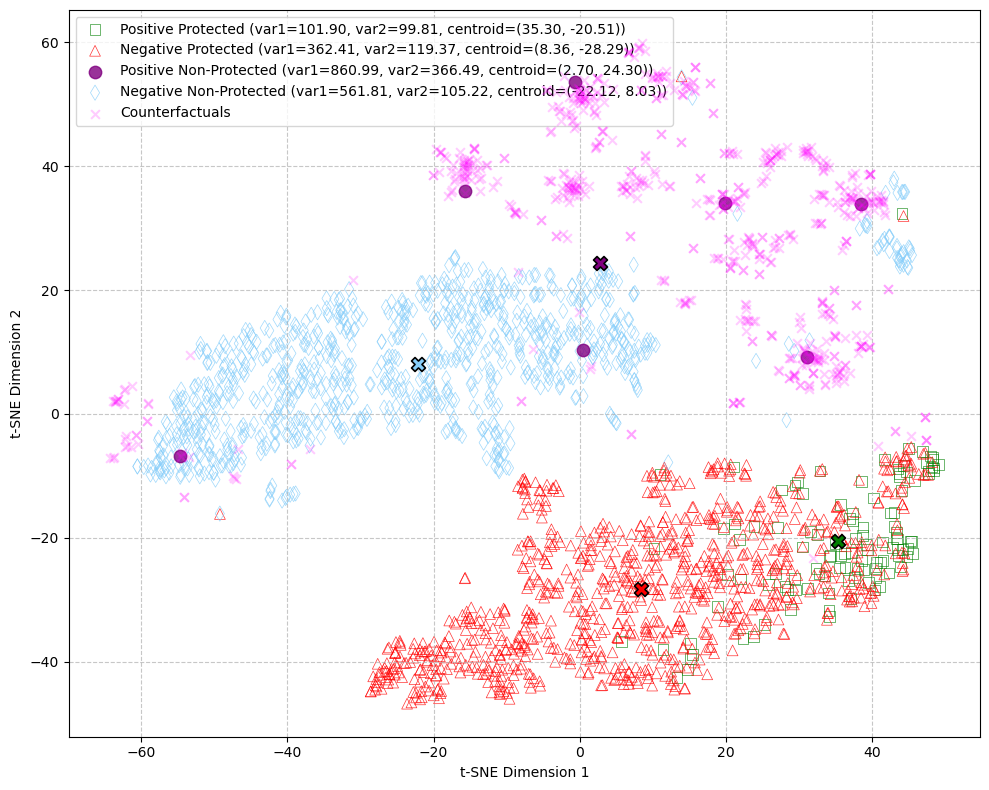

In [ ]:
feature_columns = [
    col for col in combined_df.columns
    if col not in ["class", "source"]
]

X = combined_df[feature_columns].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

combined_df["tsne_1"] = X_tsne[:, 0]
combined_df["tsne_2"] = X_tsne[:, 1]

# Split back
orig_df = combined_df[combined_df["source"] == "original"]
cf_df = combined_df[combined_df["source"] == "counterfactual"]

#Create group labels for original instances


group_labels = np.array([''] * len(orig_df), dtype=object)

group_labels[(orig_df['racepctblack'] == 1) & (orig_df['class'] == 1)] = 'Positive Protected'
group_labels[(orig_df['racepctblack'] == 1) & (orig_df['class'] == -1)] = 'Negative Protected'
group_labels[(orig_df['racepctblack'] == 0) & (orig_df['class'] == 1)] = 'Positive Non-Protected'
group_labels[(orig_df['racepctblack'] == 0) & (orig_df['class'] == -1)] = 'Negative Non-Protected'

group_info = {
    'Positive Protected': {'color': 'green', 'marker': 's'},
    'Negative Protected': {'color': 'red', 'marker': '^'},
    'Positive Non-Protected': {'color': 'purple', 'marker': 'o'},
    'Negative Non-Protected': {'color': 'lightskyblue', 'marker': 'd'}
}

# Plot original instances

plt.figure(figsize=(10, 8))

for group, info in group_info.items():
    mask = group_labels == group
    if np.sum(mask) > 0:

        var_tsne1 = np.var(orig_df.loc[mask, "tsne_1"])
        var_tsne2 = np.var(orig_df.loc[mask, "tsne_2"])

        x_centroid = np.mean(orig_df.loc[mask, "tsne_1"])
        y_centroid = np.mean(orig_df.loc[mask, "tsne_2"])

        label = (
            f"{group} "
            f"(var1={var_tsne1:.2f}, var2={var_tsne2:.2f}, "
            f"centroid=({x_centroid:.2f}, {y_centroid:.2f}))"
        )

        z = 10 if group == 'Positive Non-Protected' else 1

        if group == 'Positive Non-Protected':
            plt.scatter(
                orig_df.loc[mask, "tsne_1"],
                orig_df.loc[mask, "tsne_2"],
                color=info['color'],
                marker=info['marker'],
                alpha=0.8,
                s=80,
                label=label,
                zorder=z
            )
        else:
            plt.scatter(
                orig_df.loc[mask, "tsne_1"],
                orig_df.loc[mask, "tsne_2"],
                facecolors='none',
                edgecolors=info['color'],
                marker=info['marker'],
                alpha=0.8,
                s=60,
                linewidths=0.5,
                label=label,
                zorder=z
            )

        # Centroid
        plt.scatter(
            x_centroid, y_centroid,
            marker='X',
            s=100,
            c=info['color'],
            edgecolors='black',
            linewidths=1.2,
            zorder=20
        )

# Overlay counterfactuals


plt.scatter(
    cf_df["tsne_1"],
    cf_df["tsne_2"],
    marker="x",
    c="magenta",
    s=40,
    alpha=0.2,
    label="Counterfactuals",
    zorder=30
)

# Plot formatting

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(
    "tsne_communities_with_counterfactuals.png",
    dpi=600,
    bbox_inches="tight"
)
plt.show()


now do the same for the counterfactuals where racepctblack could be changed


In [ ]:
all_counterfactuals_racepctblack=[]
total_feature_difference=[]
for idx, model in enumerate(models_adafair_communities):
    print(f"Processing model {idx+1}/5...")

    random.seed(SEED)
    np.random.seed(SEED)
    
    # Wrap model for DiCE
    m = dice_ml.Model(model=model, backend="sklearn")
    
    # Create DiCE explainer
    exp = dice_ml.Dice(d, m, method="random")

    model_feature_difference=[]
    for row in query_instances.itertuples(index=False, name=None):  # row is a tuple of values
        query_instance_df = pd.DataFrame([row], columns=query_instances.columns)

        instance_counterfactual = exp.generate_counterfactuals(
        query_instances=query_instance_df,
        total_CFs=20,
        desired_class="opposite",
        proximity_weight=1.0,
        diversity_weight=1.0,
        features_to_vary="all")    

        cfs_df = instance_counterfactual.cf_examples_list[0].final_cfs_df
        cfs_df = cfs_df.drop(columns=[outcome_name], errors="ignore")

        feature_cols = query_instance_df.columns.tolist()  # all features, including racepctblack

        for col in feature_cols:
            cfs_df[col] = pd.to_numeric(cfs_df[col], errors='coerce')

        for col in feature_cols:
            if cfs_df[col].isna().any():
                cfs_df.loc[cfs_df[col].isna(), col] = query_instance_df.at[0, col]

        original = query_instance_df.iloc[0]           
        instance_distance = cfs_df - original          
        instance_distance_mean = instance_distance.mean()

        all_counterfactuals_racepctblack.append(cfs_df)
        model_feature_difference.append(instance_distance_mean)

    model_feature_difference_avg = pd.concat(
        model_feature_difference, axis=1
    ).mean(axis=1)  

    total_feature_difference.append(model_feature_difference_avg)      

total_feature_difference_avg = pd.concat(
    total_feature_difference, axis=1
).mean(axis=1) 
print(total_feature_difference_avg)

Processing model 1/5...


100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Processing model 2/5...


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


UserConfigValidationException: No counterfactuals found for any of the query points! Kindly check your configuration.

see how many times racepctblack changed. Not many however stil the most important feature

In [ ]:
counterfactuals_racepctblack_df = pd.concat(all_counterfactuals_racepctblack, ignore_index=True)
print(counterfactuals_racepctblack_df["racepctblack"].value_counts())
race_1_df = counterfactuals_racepctblack_df[
    counterfactuals_racepctblack_df["racepctblack"] == 1.0
]

0.0    156
1.0      4
Name: racepctblack, dtype: int64


In [ ]:
# Mark source
orig_df = df_communities.copy()
orig_df["source"] = "original"


cf_df_racepctblack = counterfactuals_racepctblack_df.copy()
cf_df_racepctblack["source"] = "counterfactual"
cf_df_racepctblack['racepctblack'] = cf_df_racepctblack['racepctblack'].astype(int)

# Align columns
cf_df_racepctblack["class"] = 1  # counterfactuals do not have a true class

combined_df_racepctblack = pd.concat([orig_df, cf_df_racepctblack], ignore_index=True)




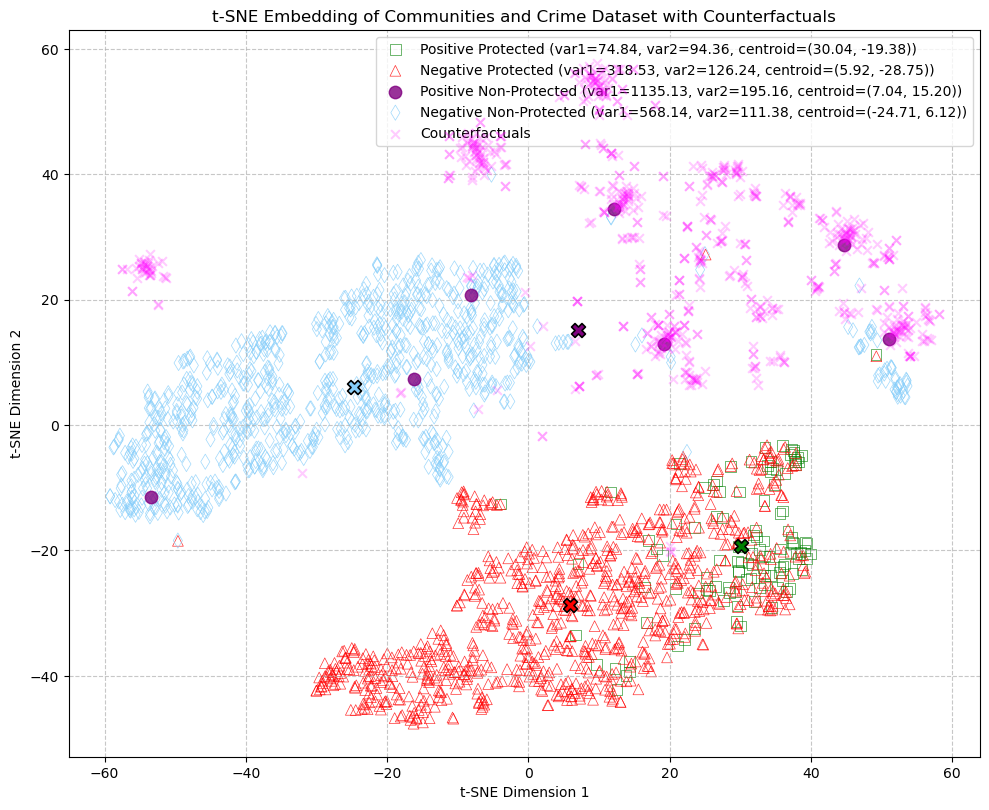

In [ ]:
feature_columns = [
    col for col in combined_df_racepctblack.columns
    if col not in ["class", "source"]
]

X = combined_df_racepctblack[feature_columns].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

combined_df_racepctblack["tsne_1"] = X_tsne[:, 0]
combined_df_racepctblack["tsne_2"] = X_tsne[:, 1]

# Split back
orig_df = combined_df_racepctblack[combined_df_racepctblack["source"] == "original"]
cf_df = combined_df_racepctblack[combined_df_racepctblack["source"] == "counterfactual"]

# Create group labels for original instances


group_labels = np.array([''] * len(orig_df), dtype=object)

group_labels[(orig_df['racepctblack'] == 1) & (orig_df['class'] == 1)] = 'Positive Protected'
group_labels[(orig_df['racepctblack'] == 1) & (orig_df['class'] == -1)] = 'Negative Protected'
group_labels[(orig_df['racepctblack'] == 0) & (orig_df['class'] == 1)] = 'Positive Non-Protected'
group_labels[(orig_df['racepctblack'] == 0) & (orig_df['class'] == -1)] = 'Negative Non-Protected'

group_info = {
    'Positive Protected': {'color': 'green', 'marker': 's'},
    'Negative Protected': {'color': 'red', 'marker': '^'},
    'Positive Non-Protected': {'color': 'purple', 'marker': 'o'},
    'Negative Non-Protected': {'color': 'lightskyblue', 'marker': 'd'}
}

# Plot original instances

plt.figure(figsize=(10, 8))

for group, info in group_info.items():
    mask = group_labels == group
    if np.sum(mask) > 0:

        var_tsne1 = np.var(orig_df.loc[mask, "tsne_1"])
        var_tsne2 = np.var(orig_df.loc[mask, "tsne_2"])

        x_centroid = np.mean(orig_df.loc[mask, "tsne_1"])
        y_centroid = np.mean(orig_df.loc[mask, "tsne_2"])

        label = (
            f"{group} "
            f"(var1={var_tsne1:.2f}, var2={var_tsne2:.2f}, "
            f"centroid=({x_centroid:.2f}, {y_centroid:.2f}))"
        )

        z = 10 if group == 'Positive Non-Protected' else 1

        if group == 'Positive Non-Protected':
            plt.scatter(
                orig_df.loc[mask, "tsne_1"],
                orig_df.loc[mask, "tsne_2"],
                color=info['color'],
                marker=info['marker'],
                alpha=0.8,
                s=80,
                label=label,
                zorder=z
            )
        else:
            plt.scatter(
                orig_df.loc[mask, "tsne_1"],
                orig_df.loc[mask, "tsne_2"],
                facecolors='none',
                edgecolors=info['color'],
                marker=info['marker'],
                alpha=0.8,
                s=60,
                linewidths=0.5,
                label=label,
                zorder=z
            )

        # Centroid
        plt.scatter(
            x_centroid, y_centroid,
            marker='X',
            s=100,
            c=info['color'],
            edgecolors='black',
            linewidths=1.2,
            zorder=20
        )

# Overlay counterfactuals

plt.scatter(
    cf_df["tsne_1"],
    cf_df["tsne_2"],
    marker="x",
    c="magenta",
    s=40,
    alpha=0.2,
    label="Counterfactuals",
    zorder=30
)

# Plot formatting

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.title("t-SNE Embedding of Communities and Crime Dataset with Counterfactuals")
plt.savefig("tsne_communities_with_counterfactuals_racepctblack.png",
    dpi=600,
    bbox_inches="tight")
plt.show()

try the adafair model on the dataset downsampling the other subgroups.


In [ ]:
# Downsample to 200 per group
neg_protected_ds = negative_protected_comm.sample(n=115, random_state=42)
neg_non_protected_ds = negative_non_protected_comm.sample(n=115, random_state=42)

# Recombine and shuffle
df_downsampled = pd.concat([
    positive_protected_comm,
    positive_non_protected_comm,
    neg_protected_ds,
    neg_non_protected_ds
]).sample(frac=1, random_state=42).reset_index(drop=True)

positive_protected_comm_downsampled = df_downsampled[(df_downsampled['racepctblack'] == 1) & (df_downsampled['class'] == 1)]
negative_protected_comm_downsampled = df_downsampled[(df_downsampled['racepctblack'] == 1) & (df_downsampled['class'] == -1)]
positive_non_protected_comm_downsampled = df_downsampled[(df_downsampled['racepctblack'] == 0) & (df_downsampled['class'] == 1)]
negative_non_protected_comm_downsampled = df_downsampled[(df_downsampled['racepctblack'] == 0) & (df_downsampled['class'] == -1)]

# Print the sizes of each group
print("Communities and Crime Dataset:")
print(f"Positive Protected: {len(positive_protected_comm_downsampled)}")
print(f"Negative Protected: {len(negative_protected_comm_downsampled)}")
print(f"Positive Non-Protected: {len(positive_non_protected_comm_downsampled)}")
print(f"Negative Non-Protected: {len(negative_non_protected_comm_downsampled)}")


Communities and Crime Dataset:
Positive Protected: 115
Negative Protected: 115
Positive Non-Protected: 7
Negative Non-Protected: 115


In [ ]:
X_communities_downsampled = df_downsampled.drop('class', axis=1).values
y_communities_downsampled = df_downsampled['class'].values
saIndex_communities = 0  # 'racepctblack' is the first column
saValue_communities = 1  # Protected group: communities with higher black population
query_instances_downsampled= positive_non_protected_comm_downsampled.drop('class', axis=1)

printing all the query instances down below in the training on downsampled and dataset with counterfactuals. However data leakage due to testing all also once used in that train split

In [ ]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_communities_downsampled = [] # save the resulsts in a list
models_adafair_communities_downsampled = [] # save the specific classifiers for DiCE
downsampled_preds=[]
# train and predict for each split saving and printing the perforrmance
for train_index, test_index in strat_suffle.split(X_communities_downsampled, y_communities_downsampled):
    X_train, X_test = X_communities_downsampled[train_index], X_communities_downsampled[test_index]
    y_train, y_test = y_communities_downsampled[train_index], y_communities_downsampled[test_index]
    classifier = AdaFair(n_estimators=200, saIndex=saIndex_communities , saValue= saValue_communities, trade_off_c=1.0, random_state= SEED)

    classifier.fit(X_train, y_train)
    y_pred_labels = classifier.predict(X_test)
    query_instances_prediction= classifier.predict(query_instances_downsampled)
    print(query_instances_prediction)
    downsampled_preds.append(query_instances_prediction)
    performance =calculate_performance(X_test, y_test, y_pred_labels,  saIndex_communities, saValue_communities)
    results_adafair_communities_downsampled.append(performance)
    models_adafair_communities_downsampled.append(classifier)
    print(performance)

[ 1  1  1  1  1 -1  1]
{'balanced_accuracy': 0.8079828937990021, 'accuracy': 0.8295454545454546, 'fairness': 0.882869249394673, 'TPR_protected': 0.75, 'TPR_non_protected': 0.0, 'TNR_protected': 0.8135593220338984, 'TNR_non_protected': 0.9464285714285714}
[-1 -1  1  1  1 -1 -1]
{'balanced_accuracy': 0.8210263720598717, 'accuracy': 0.8465909090909091, 'fairness': 0.7746444032158317, 'TPR_protected': 0.7857142857142857, 'TPR_non_protected': 0.2, 'TNR_protected': 0.7959183673469388, 'TNR_non_protected': 0.9848484848484849}
[-1  1  1 -1  1  1 -1]
{'balanced_accuracy': 0.7905915894511761, 'accuracy': 0.8068181818181818, 'fairness': 0.8562029088924802, 'TPR_protected': 0.7758620689655172, 'TPR_non_protected': 0.0, 'TNR_protected': 0.8064516129032258, 'TNR_non_protected': 0.8867924528301887}
[-1 -1  1 -1  1 -1  1]
{'balanced_accuracy': 0.8697077690662864, 'accuracy': 0.875, 'fairness': 0.753960368714467, 'TPR_protected': 0.9090909090909091, 'TPR_non_protected': 0.3333333333333333, 'TNR_protect

train the model now on the data set combined with all the counterfactuals 

In [ ]:
# combined_df_racepctblack
positive_protected_comm_combined = combined_df_racepctblack[(combined_df_racepctblack['racepctblack'] == 1) & (combined_df_racepctblack['class'] == 1)]
negative_protected_comm_combined = combined_df_racepctblack[(combined_df_racepctblack['racepctblack'] == 1) & (combined_df_racepctblack['class'] == -1)]
positive_non_protected_comm_combined = combined_df_racepctblack[(combined_df_racepctblack['racepctblack'] == 0) & (combined_df_racepctblack['class'] == 1)]
negative_non_protected_comm_combined = combined_df_racepctblack[(combined_df_racepctblack['racepctblack'] == 0) & (combined_df_racepctblack['class'] == -1)]

# Print the sizes of each group
print("Communities and Crime Dataset:")
print(f"Positive Protected: {len(positive_protected_comm_combined)}")
print(f"Negative Protected: {len(negative_protected_comm_combined)}")
print(f"Positive Non-Protected: {len(positive_non_protected_comm_combined)}")
print(f"Negative Non-Protected: {len(negative_non_protected_comm_combined)}")
queries = positive_non_protected_comm_combined[
    positive_non_protected_comm_combined["source"] == "original"
]



Communities and Crime Dataset:
Positive Protected: 130
Negative Protected: 923
Positive Non-Protected: 690
Negative Non-Protected: 949


In [ ]:
X_communities_combined = combined_df_racepctblack.drop(['class', "source", "tsne_1", "tsne_2"], axis=1).values
query_instances_combined = queries.drop(['class', "source", "tsne_1", "tsne_2"], axis=1)
y_communities_combined = combined_df_racepctblack['class'].values
saIndex_communities = 0  # 'racepctblack' is the first column
saValue_communities = 1  # Protected group: communities with higher black population

need to find a way to just get the original query instances. while positive_non_protected_comm_combined has all also the counterfactuals

In [ ]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_communities_combined = [] # save the resulsts in a list
models_adafair_communities_combined = [] # save the specific classifiers for DiCE
combined_preds=[]
# train and predict for each split saving and printing the perforrmance
for train_index, test_index in strat_suffle.split(X_communities_combined, y_communities_combined):
    X_train, X_test = X_communities_combined[train_index], X_communities_combined[test_index]
    y_train, y_test = y_communities_combined[train_index], y_communities_combined[test_index]
    classifier = AdaFair(n_estimators=200, saIndex=saIndex_communities , saValue= saValue_communities, trade_off_c=1.0, random_state= SEED)

    classifier.fit(X_train, y_train)
    y_pred_labels = classifier.predict(X_test)
    query_instances_prediction= classifier.predict(query_instances_combined)
    print(query_instances_prediction)
    combined_preds.append(query_instances_prediction)
    performance =calculate_performance(X_test, y_test, y_pred_labels,  saIndex_communities, saValue_communities)
    results_adafair_communities_combined.append(performance)
    models_adafair_communities_combined.append(classifier)
    print(performance)


[ 1 -1 -1 -1  1 -1 -1]
{'balanced_accuracy': 0.9048467792370232, 'accuracy': 0.9219910846953938, 'fairness': 0.39428412232873555, 'TPR_protected': 0.5737704918032787, 'TPR_non_protected': 0.9111747851002865, 'TNR_protected': 0.9199134199134199, 'TNR_non_protected': 0.9767932489451476}
[ 1 -1 -1 -1 -1 -1 -1]
{'balanced_accuracy': 0.8889931207004378, 'accuracy': 0.912332838038633, 'fairness': 0.4376698527084587, 'TPR_protected': 0.5079365079365079, 'TPR_non_protected': 0.8876080691642652, 'TNR_protected': 0.9190371991247265, 'TNR_non_protected': 0.9770354906054279}
[ 1 -1 -1 -1  1 -1 -1]
{'balanced_accuracy': 0.9130810923493851, 'accuracy': 0.9286775631500743, 'fairness': 0.3950237605956701, 'TPR_protected': 0.5689655172413793, 'TPR_non_protected': 0.9232954545454546, 'TNR_protected': 0.9321663019693655, 'TNR_non_protected': 0.9728601252609603}
[ 1 -1 -1 -1  1 -1 -1]
{'balanced_accuracy': 0.8921174692516156, 'accuracy': 0.9138187221396731, 'fairness': 0.325983518787041, 'TPR_protected': 

follow up for each data point "name it" and visualize with name. and show which of the models manage to predict it correctly

In [ ]:
for df in [query_instances, query_instances_downsampled, query_instances_combined]:
    if 'racepctblack' in df.columns:
        df['racepctblack'] = df['racepctblack'].astype(float)
hash_columns = [col for col in query_instances.columns if col not in ['hash', 'tag', 'racepctblack']]

def compute_row_hash_no_protected(row):
    return hashlib.md5(str(tuple(row[hash_columns])).encode()).hexdigest()

query_instances['hash'] = query_instances.apply(compute_row_hash_no_protected, axis=1)

# For downsampled
query_instances_downsampled['hash'] = query_instances_downsampled.apply(compute_row_hash_no_protected, axis=1)

# For combined
query_instances_combined['hash'] = query_instances_combined.apply(compute_row_hash_no_protected, axis=1)

# Get unique hashes and assign tags (sort for consistent ordering)
unique_hashes = sorted(set(query_instances['hash']))
hash_to_tag = {h: f"Inst{i+1}" for i, h in enumerate(unique_hashes)}

# Apply tags to each df
query_instances['tag'] = query_instances['hash'].map(hash_to_tag)
query_instances_downsampled['tag'] = query_instances_downsampled['hash'].map(hash_to_tag)
query_instances_combined['tag'] = query_instances_combined['hash'].map(hash_to_tag)

# Print to verify matching
print("Original tags:", query_instances['tag'].tolist())
print("Downsampled tags:", query_instances_downsampled['tag'].tolist())
print("Combined tags:", query_instances_combined['tag'].tolist())

Original tags: ['Inst3', 'Inst6', 'Inst5', 'Inst7', 'Inst2', 'Inst1', 'Inst4']
Downsampled tags: ['Inst6', 'Inst7', 'Inst2', 'Inst5', 'Inst3', 'Inst1', 'Inst4']
Combined tags: ['Inst3', 'Inst6', 'Inst5', 'Inst7', 'Inst2', 'Inst1', 'Inst4']


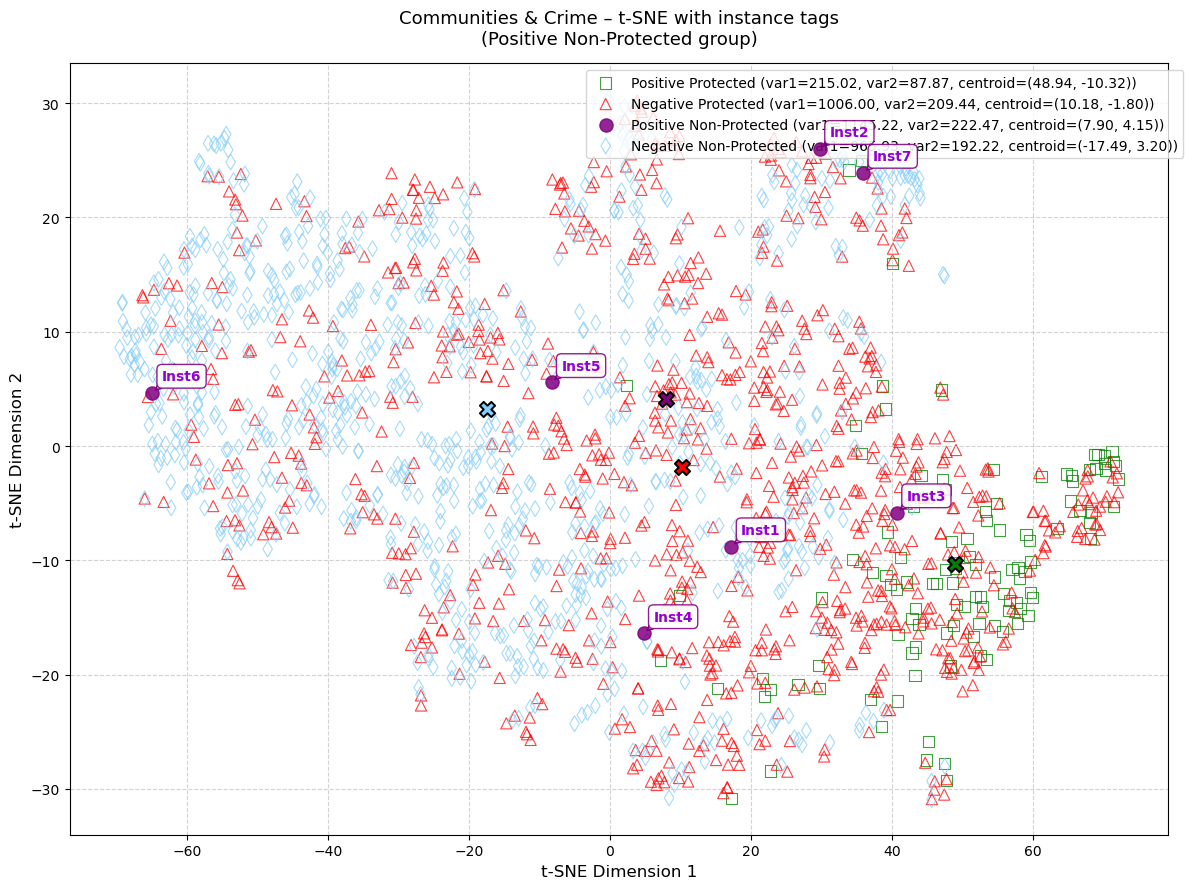

In [ ]:
feature_columns = [col for col in df_communities.columns if col not in ['racepctblack', 'class',"tag"]]
X = df_communities[feature_columns].values

# Scale features before t-SNE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Critical: add coordinates to dataframe
df_communities['tsne_1'] = X_tsne[:, 0]
df_communities['tsne_2'] = X_tsne[:, 1]

# Create group labels for all instances
group_labels = np.array([''] * len(df_communities), dtype=object)
group_labels[(df_communities['racepctblack'] == 1) & (df_communities['class'] == 1)] = 'Positive Protected'
group_labels[(df_communities['racepctblack'] == 1) & (df_communities['class'] == -1)] = 'Negative Protected'
group_labels[(df_communities['racepctblack'] == 0) & (df_communities['class'] == 1)] = 'Positive Non-Protected'
group_labels[(df_communities['racepctblack'] == 0) & (df_communities['class'] == -1)] = 'Negative Non-Protected'

# Define colors and markers for each group
group_info = {
    'Positive Protected': {'color': 'green', 'marker': 's'},
    'Negative Protected': {'color': 'red', 'marker': '^'},
    'Positive Non-Protected': {'color': 'purple', 'marker': 'o'},
    'Negative Non-Protected': {'color': 'lightskyblue', 'marker': 'd'}
}

# Create scatter plot
plt.figure(figsize=(12, 9))
for group, info in group_info.items():
    mask = group_labels == group
    if mask.sum() > 0:
        var1 = np.var(df_communities.loc[mask, 'tsne_1'])
        var2 = np.var(df_communities.loc[mask, 'tsne_2'])
        cx = df_communities.loc[mask, 'tsne_1'].mean()
        cy = df_communities.loc[mask, 'tsne_2'].mean()

        label = f"{group} (var1={var1:.2f}, var2={var2:.2f}, centroid=({cx:.2f}, {cy:.2f}))"

        zorder = 10 if group == 'Positive Non-Protected' else 1

        if group == 'Positive Non-Protected':
            plt.scatter(
                df_communities.loc[mask, 'tsne_1'],
                df_communities.loc[mask, 'tsne_2'],
                color=info['color'], marker=info['marker'],
                s=90, alpha=0.85, label=label, zorder=zorder
            )
        else:
            plt.scatter(
                df_communities.loc[mask, 'tsne_1'],
                df_communities.loc[mask, 'tsne_2'],
                facecolors='none', edgecolors=info['color'],
                marker=info['marker'], s=65, alpha=0.75,
                linewidths=0.8, label=label, zorder=zorder
            )

        # centroid
        plt.scatter(cx, cy, marker='X', s=120,
                    c=info['color'], edgecolors='black',
                    linewidths=1.4, zorder=20)

mask_pos_nonprot = (df_communities['racepctblack'] == 0) & (df_communities['class'] == 1)

# Reset index to make sure positional alignment is safe
pos_nonprot_df = df_communities[mask_pos_nonprot].reset_index(drop=True)

# Assign tags (assuming query_instances tags are in the correct order)
pos_nonprot_df['tag'] = query_instances['tag'].values

# Annotate
for i, row in pos_nonprot_df.iterrows():
    plt.annotate(
        text=row['tag'],
        xy=(row['tsne_1'], row['tsne_2']),
        xytext=(7, 7),                    # offset in points
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        color='darkviolet',
        ha='left',
        va='bottom',
        bbox=dict(
            facecolor='white',
            edgecolor='purple',
            boxstyle='round,pad=0.35',
            alpha=0.88
        ),
        arrowprops=dict(
            arrowstyle='->',
            color='purple',
            lw=1.1,
            connectionstyle='arc3,rad=0.12'
        ),
        zorder=35
    )

# Plot formatting

plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('Communities & Crime – t-SNE with instance tags\n(Positive Non-Protected group)', fontsize=13, pad=14)
plt.legend(fontsize=10, loc='upper right', bbox_to_anchor=(1.02, 1))
plt.grid(True, linestyle='--', alpha=0.55)
plt.tight_layout()

plt.savefig('tsne_communities_with_instance_tags.png', dpi=160, bbox_inches='tight')
plt.show()

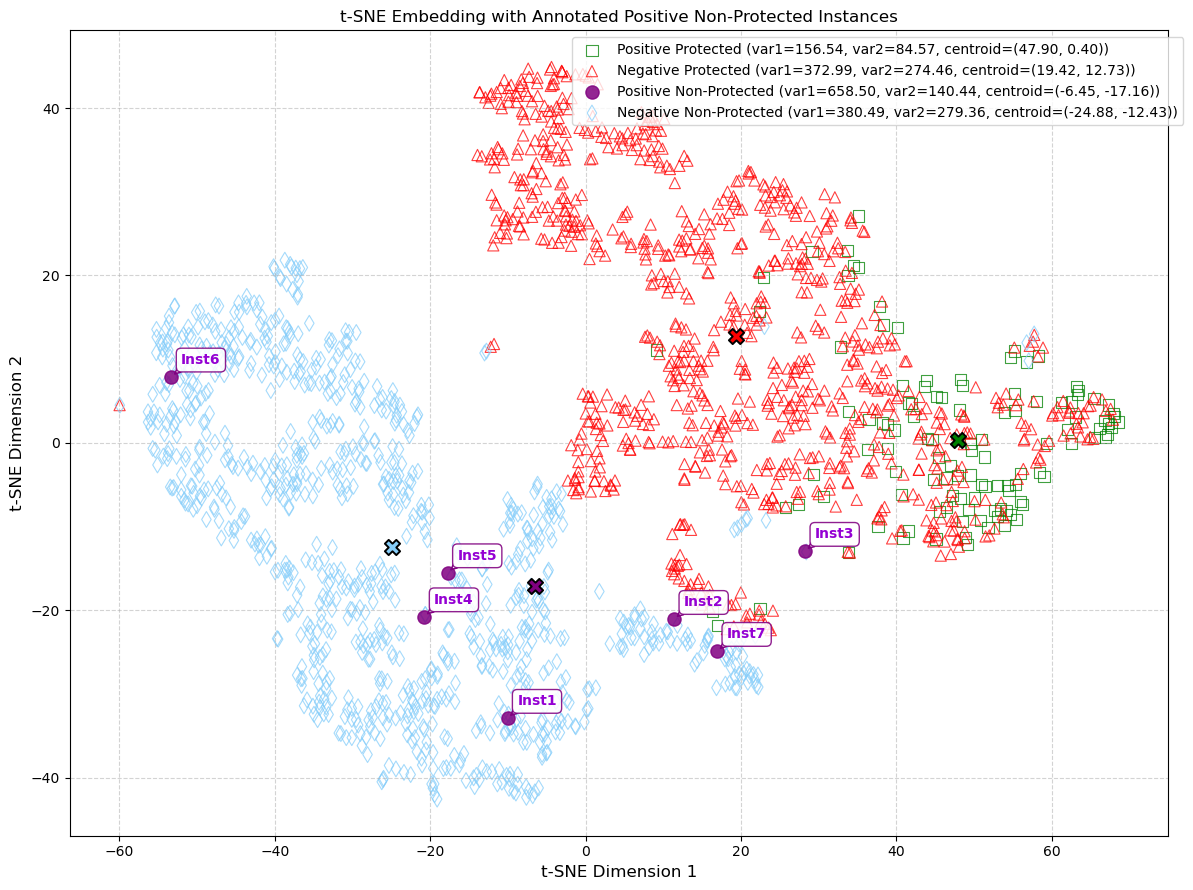

In [ ]:
feature_columns = [col for col in df_communities.columns if col not in [ 'class','tag']]
X = df_communities[feature_columns].values

# Scale features before t-SNE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Critical: add coordinates to dataframe
df_communities['tsne_1'] = X_tsne[:, 0]
df_communities['tsne_2'] = X_tsne[:, 1]

# Create group labels for all instances
group_labels = np.array([''] * len(df_communities), dtype=object)
group_labels[(df_communities['racepctblack'] == 1) & (df_communities['class'] == 1)] = 'Positive Protected'
group_labels[(df_communities['racepctblack'] == 1) & (df_communities['class'] == -1)] = 'Negative Protected'
group_labels[(df_communities['racepctblack'] == 0) & (df_communities['class'] == 1)] = 'Positive Non-Protected'
group_labels[(df_communities['racepctblack'] == 0) & (df_communities['class'] == -1)] = 'Negative Non-Protected'

# Define colors and markers for each group
group_info = {
    'Positive Protected': {'color': 'green', 'marker': 's'},
    'Negative Protected': {'color': 'red', 'marker': '^'},
    'Positive Non-Protected': {'color': 'purple', 'marker': 'o'},
    'Negative Non-Protected': {'color': 'lightskyblue', 'marker': 'd'}
}

# Create scatter plot
plt.figure(figsize=(12, 9))
for group, info in group_info.items():
    mask = group_labels == group
    if mask.sum() > 0:
        var1 = np.var(df_communities.loc[mask, 'tsne_1'])
        var2 = np.var(df_communities.loc[mask, 'tsne_2'])
        cx = df_communities.loc[mask, 'tsne_1'].mean()
        cy = df_communities.loc[mask, 'tsne_2'].mean()

        label = f"{group} (var1={var1:.2f}, var2={var2:.2f}, centroid=({cx:.2f}, {cy:.2f}))"

        zorder = 10 if group == 'Positive Non-Protected' else 1

        if group == 'Positive Non-Protected':
            plt.scatter(
                df_communities.loc[mask, 'tsne_1'],
                df_communities.loc[mask, 'tsne_2'],
                color=info['color'], marker=info['marker'],
                s=90, alpha=0.85, label=label, zorder=zorder
            )
        else:
            plt.scatter(
                df_communities.loc[mask, 'tsne_1'],
                df_communities.loc[mask, 'tsne_2'],
                facecolors='none', edgecolors=info['color'],
                marker=info['marker'], s=65, alpha=0.75,
                linewidths=0.8, label=label, zorder=zorder
            )

        # centroid
        plt.scatter(cx, cy, marker='X', s=120,
                    c=info['color'], edgecolors='black',
                    linewidths=1.4, zorder=20)


mask_pos_nonprot = (df_communities['racepctblack'] == 0) & (df_communities['class'] == 1)

# Reset index to make sure positional alignment is safe
pos_nonprot_df = df_communities[mask_pos_nonprot].reset_index(drop=True)

# Assign tags (assuming query_instances tags are in the correct order)
pos_nonprot_df['tag'] = query_instances['tag'].values

# Annotate
for i, row in pos_nonprot_df.iterrows():
    plt.annotate(
        text=row['tag'],
        xy=(row['tsne_1'], row['tsne_2']),
        xytext=(7, 7),                    # offset in points
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        color='darkviolet',
        ha='left',
        va='bottom',
        bbox=dict(
            facecolor='white',
            edgecolor='purple',
            boxstyle='round,pad=0.35',
            alpha=0.88
        ),
        arrowprops=dict(
            arrowstyle='->',
            color='purple',
            lw=1.1,
            connectionstyle='arc3,rad=0.12'
        ),
        zorder=35
    )

# Plot formatting

plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(fontsize=10, loc='upper right', bbox_to_anchor=(1.02, 1))
plt.grid(True, linestyle='--', alpha=0.55)
plt.title("t-SNE Embedding with Annotated Positive Non-Protected Instances")
plt.tight_layout()

plt.savefig('tsne_communities_with_instance_tags_racepctblack.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Get tags from dataframes
original_tags = query_instances['tag'].tolist()
downsampled_tags = query_instances_downsampled['tag'].tolist()
combined_tags = query_instances_combined['tag'].tolist()

# Define predictions for each dataset (each row is a model)
original_preds = np.array(original_preds)
downsampled_preds = np.array(downsampled_preds)
combined_preds = np.array(combined_preds)

# Ground truth is 1 for all instances
ground_truth = 1

# Calculate accuracies for each dataset
accuracy_dict = {}

# Original dataset
for idx, inst in enumerate(original_tags):
    preds = original_preds[:, idx]
    accuracy = (preds == ground_truth).sum() / len(preds)
    if inst not in accuracy_dict:
        accuracy_dict[inst] = {}
    accuracy_dict[inst]['Original'] = accuracy

# Downsampled dataset
for idx, inst in enumerate(downsampled_tags):
    preds = downsampled_preds[:, idx]
    accuracy = (preds == ground_truth).sum() / len(preds)
    if inst not in accuracy_dict:
        accuracy_dict[inst] = {}
    accuracy_dict[inst]['Downsampled'] = accuracy

# Combined dataset
for idx, inst in enumerate(combined_tags):
    preds = combined_preds[:, idx]
    accuracy = (preds == ground_truth).sum() / len(preds)
    if inst not in accuracy_dict:
        accuracy_dict[inst] = {}
    accuracy_dict[inst]['Combined'] = accuracy

# Create dataframe
accuracy_df = pd.DataFrame.from_dict(accuracy_dict, orient='index')
accuracy_df.index.name = 'Instance'
accuracy_df = accuracy_df.reset_index()

accuracy_df['Mean'] = accuracy_df[['Original', 'Downsampled', 'Combined']].mean(axis=1)
accuracy_df['Std'] = accuracy_df[['Original', 'Downsampled', 'Combined']].std(axis=1)

# Optional: display rounded nicely for readability
accuracy_df[['Mean', 'Std']] = accuracy_df[['Mean', 'Std']].round(3)

# Display the dataframe
accuracy_df

,Instance,Original,Downsampled,Combined,Mean,Std
0,Inst3,0.6,1.0,1.0,0.867,0.231
1,Inst6,0.4,0.4,0.0,0.267,0.231
2,Inst5,0.8,0.6,0.0,0.467,0.416
3,Inst7,0.8,0.6,0.2,0.533,0.306
4,Inst2,0.6,0.8,0.8,0.733,0.115
5,Inst1,0.4,0.4,0.0,0.267,0.231
6,Inst4,0.4,0.4,0.0,0.267,0.231


In [ ]:
accuracy_df.to_latex(
    "accuracy_df.tex",  # filename to save the table
    caption="Per-instance accuracy across models for the positive non-protected subgroup.",
    label="tab:accuracy_per_instance",
)